# Maximum Independent Sets with Analog Hamiltonian Simulation

## Introduction to the maximum independent set problem

In this notebook, we'll demonstrate how to set up a unit disk graph and solve for its maximum independent set using the Amazon Braket analog Hamiltonian simulation (AHS) local simulator. This code can then be generalized to run on the actual AHS device, QuEra's Aquila, as shown in this [AWS Quantum Technologies blog post](https://aws.amazon.com/blogs/quantum-computing/optimization-with-rydberg-atom-based-quantum-processor/).

Finding a maximum independent set (MIS) is a common problem in graph theory with many real-life applications. What is an "independent set", let alone a "maximum" one? Consider a graph with vertices $V$ and edges $E$. An independent set is any subset $V_{is}$ of $V$ such that no pair of vertices in $V_{is}$ are connected by an edge in $E$. The *maximum* independent set is the largest such subset. Let's make this a little more concrete with a visual example.

![Raw graph](py_graph.png)

We can select vertices to be part of the maximum independent set:

![MIS graph](mis_graph.png)

In this example, we see that the vertices in the MIS (the red ones) are not connected by any edge. We can also see there is no way to add another vertex to the set without it being connected to another vertex already present. We can also determine that no larger independent set can be found through brute-force enumeration of all possible independent sets (not shown).

Finding maximum independent sets is a problem with many applications. Consider, for example, a business owner who wants to put branches of their chain store on as many street corners as possible so that potential customers never have to walk very far to find a location. However, the owner doesn't want to have multiple branches at the same intersection — this is inefficient. Maximizing the number of branches in a city, given its particular street grid, while avoiding opening branches which are too close together is an example of the MIS problem. There are many other applications, including to "knapsack packing" style problems, routing, and others.

## Unit disk graphs

A unit disk graph is a graph in which, if and only if any two vertices are within a unit disk radius of each other, they are connected. This type of graph is very well suited for AHS devices because it can be simulated with no overhead — the number of atoms needed in the trap corresponds exactly to the total number of vertices in the graph. The phenomenon of Rydberg blockade enforces the condition that vertices connected by an edge cannot both be in the independent set.

In [1]:
# necessary imports
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import optimize

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.driving_field import DrivingField
from braket.devices import LocalSimulator
from braket.timings.time_series import TimeSeries

In [2]:
# constants
atoms_w = 3
atoms_l = 4
blockade_radius = 7.5
np.random.seed(92)

This function generates both the `AtomArrangement`, which will be passed to the simualtor or AHS device, and the graph it corresponds to. We set up the atoms in a square grid, such that nearest- (horizontal or vertical neighbors) and next-nearest-neighbors (diagonal neighbors) are within the unit disk range. In the graph this means the next-nearest-neighbors are connected by an edge. We perform a random dropout on this square grid — removing some of the atoms — to generate a more interesting graph.

In [3]:
def generate_unit_disk(atoms_l: int, atoms_w: int, scale=4.0 * 1e-6, dropout=0.45):
    atom_list = []
    edge_dict = {}
    atom_to_edge = {}
    for ii in range(atoms_l):
        for jj in range(atoms_w):
            atom_list.append((ii * scale, jj * scale))
            atom_to_edge[ii * scale, jj * scale] = ii * atoms_w + jj
            edge_dict[ii * atoms_w + jj] = []
            if jj < atoms_w - 1:
                edge_dict[ii * atoms_w + jj].append(ii * atoms_w + jj + 1)
            if ii < atoms_l - 1:
                edge_dict[ii * atoms_w + jj].append((ii + 1) * atoms_w + jj)
            if ii < atoms_l - 1 and jj < atoms_w - 1:
                # nearest neighbor
                edge_dict[ii * atoms_w + jj].append((ii + 1) * atoms_w + jj + 1)
            if jj > 0 and ii < atoms_l - 1:
                # nearest neighbor
                edge_dict[ii * atoms_w + jj].append((ii + 1) * atoms_w + jj - 1)

    graph = nx.from_dict_of_lists(edge_dict)

    # perform dropout
    new_len = int(np.round(len(atom_list) * (1 - dropout)))
    atom_arr = np.empty(len(atom_list), dtype=object)
    atom_arr[:] = atom_list
    remaining_atom_list = np.random.choice(atom_arr, new_len, replace=False)

    atoms = AtomArrangement()
    for atom in atom_list:
        for remain in remaining_atom_list:
            #keep atom arrangement consistent with graph
            if atom == remain:
                atoms.add(atom)
                
    graph.remove_nodes_from(
        [atom_to_edge[atom] for atom in set(atom_list) - set(list(remaining_atom_list))],
    )

    return atoms, graph

In [4]:
atoms, graph = generate_unit_disk(atoms_l, atoms_w)

Let's plot the graph:

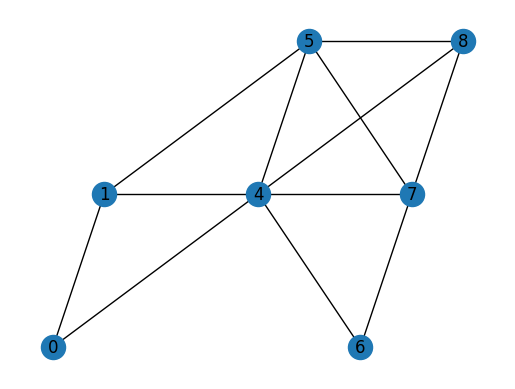

In [5]:
fig, ax = plt.subplots()
pos = {ii: (ii / atoms_w, ii % atoms_w) for ii in graph.nodes()}
nx.draw(graph, pos=pos, ax=ax, with_labels=True)
plt.show()

Now we can define our loss function. For this problem, we'll use the Quantum Adiabatic Algorithm to train variational parameters. These parameters encode the shape of the global detuning waveform `Delta`. We'll train 3 variational parameters. As these parameters change, so too does the shape of the global detuning waveform.

In [6]:
def loss_piecewise_linear(atoms: AtomArrangement, x: list):
    assert len(x) == 3
    Delta_start = -13 * 2 * np.pi * 1e6
    Delta_0 = 11 * 2 * np.pi * 1e6
    Delta_end = 11 * 2 * np.pi * 1e6

    Omega_max = 2.5e7  # 4 * 2 * np.pi * 1e6
    T_max = 0.6 * 1e-6

    Deltas = TimeSeries()
    Deltas.put(0.0, Delta_start)
    Deltas.put(0.05 * 1e-6, Delta_start)
    Deltas.put(0.2 * 1e-6, Delta_0 * x[0])
    Deltas.put(0.3 * 1e-6, Delta_0 * x[1])
    Deltas.put(0.4 * 1e-6, Delta_0 * x[2])
    Deltas.put(0.55 * 1e-6, Delta_end)
    Deltas.put(T_max, Delta_end)

    # keep amplitude (Rabi frequency) constant once we turn it on
    Omegas = TimeSeries()
    Omegas.put(0.0, 0.0)
    Omegas.put(0.05 * 1e-6, 0.0)
    Omegas.put(0.1 * 1e-6, Omega_max)
    Omegas.put(0.5 * 1e-6, Omega_max)
    Omegas.put(0.55 * 1e-6, 0.0)
    Omegas.put(T_max, 0.0)

    # do not use the phase parameter
    Phi = TimeSeries().put(0.0, 0.0).put(T_max, 0.0)

    # for this problem, our Hamiltonian has no local detuning
    H = DrivingField(amplitude=Omegas, phase=Phi, detuning=Deltas)

    program = AnalogHamiltonianSimulation(hamiltonian=H, register=atoms)
    device = LocalSimulator("braket_ahs")

    # if you want to use Aquila, uncomment these lines
    # keep in mind that you may have to modify the fields
    # device = AwsDevice(Devices.QuEra.Aquila)
    # program = program.discretize(device)

    # run the AHS program and extract measurements
    results = device.run(program, shots=1000, steps=100).result()

    r_counts = []

    # states are one of:
    # 'e' - empty
    # 'r' - Rydberg
    # 'g' - groundstate
    states = ["e", "r", "g"]
    for shot in results.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state_labels = [states[s_idx] for s_idx in state_idx]
        r_count = np.count_nonzero([sl == "r" for sl in state_labels]) / len(atoms)
        r_counts.append(r_count)

    # the mean density of Rydberg states - this will be our cost
    # higher is better, as it corresponds to a larger independent set
    density_sum = np.mean(r_counts)

    return -density_sum, results, Deltas

In [7]:
start = time.time()
# initial waveform parameters
x0 = [0.1, 0.8, 0.8]
initial_rydberg_density, initial_registers, initial_Deltas = loss_piecewise_linear(atoms, x0)
print(f"Initial density: {initial_rydberg_density}")
# perform optimization
optresult = optimize.minimize(
    lambda x: loss_piecewise_linear(atoms, x)[0],
    x0,
    method="Nelder-Mead",
    options={"maxiter": 10},
)
final_rydberg_density, final_registers, final_Deltas = loss_piecewise_linear(atoms, optresult.x)
print(f"Final density: {final_rydberg_density}")
print(f"Final values: {optresult.x}")
stop = time.time()
print(f"Time to run AHS with local simulator: {stop - start}")

Initial density: -0.3691428571428571
Final density: -0.3812857142857143
Final values: [0.10398148 0.6        0.94074074]
Time to run AHS with local simulator: 31.821674346923828


Now let's visualize the solutions generated by the AHS program, to verify that they are independent sets and to see how large they are.

Independent set of 0-th most likely outcome


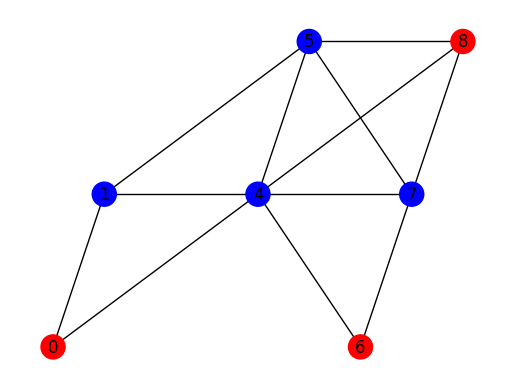

Independent set of 1-th most likely outcome


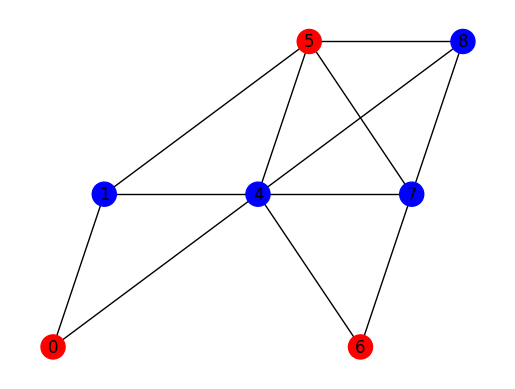

Independent set of 2-th most likely outcome


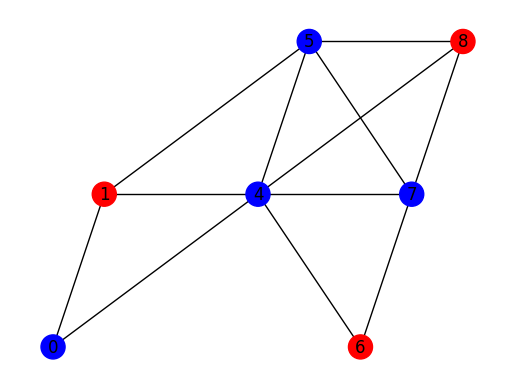

Independent set of 3-th most likely outcome


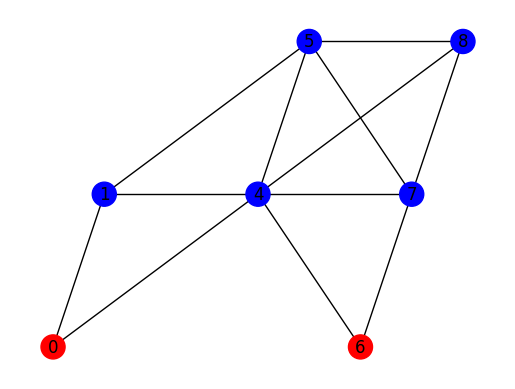

Independent set of 4-th most likely outcome


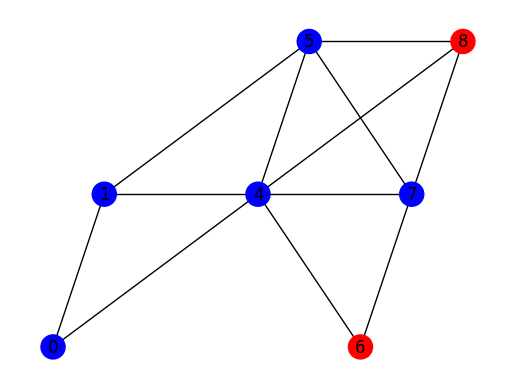

In [8]:
from collections import Counter

states = ["e", "r", "g"]
state_labels = []
for shot in final_registers.measurements:
    pre = shot.pre_sequence
    post = shot.post_sequence
    state_idx = np.array(pre) * (1 + np.array(post))
    state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

occurence_count = Counter(state_labels)

most_frequent_regs = occurence_count.most_common(5)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots()
    vert_colors = [
        "red" if (most_frequent_regs[ii][0][i] == "r") else "blue"
        for i in range(len(most_frequent_regs[ii][0]))
    ]
    print(f"Independent set of {ii}-th most likely outcome")
    nx.draw(
        graph,
        pos={ii: (ii / atoms_w, ii % atoms_w) for ii in graph.nodes()},
        ax=ax,
        with_labels=True,
        node_color=vert_colors,
    )
    plt.show()

Indeed, the most likely solution is the maximum independent set. Other solutions are either missing vertices or invalid.

We can also visualize the initial and final waveforms:

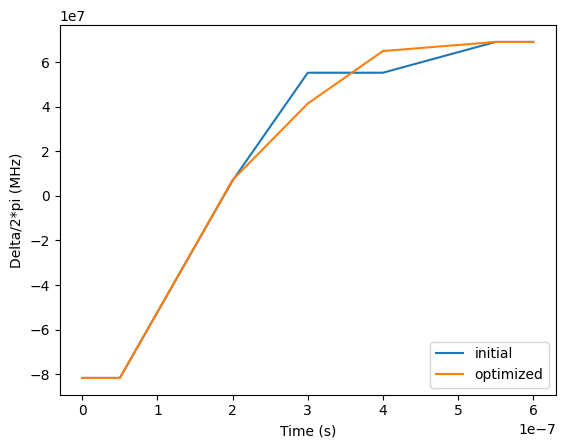

In [9]:
fig, ax = plt.subplots()
ax.plot(initial_Deltas.times(), initial_Deltas.values())
ax.plot(final_Deltas.times(), final_Deltas.values())
ax.set_xlabel("Time (s)")
ax.set_ylabel("Delta/2*pi (MHz)")
ax.legend(["initial", "optimized"], loc="lower right")
plt.show()

## Conclusion

In this example, we generated a unit disk graph and found its maximum independent set. Because we are using the Amazon Braket local AHS simulator, we are restricted to relatively small graphs of fewer than 15 vertices. QuEra's Aquila device, by contrast, can handle far larger graphs of up to 256 vertices as shown in the AWS Quantum Technologies blog post [Optimization with a Rydberg atom-based quantum processor](https://aws.amazon.com/blogs/quantum-computing/optimization-with-rydberg-atom-based-quantum-processor/). See the [Braket Developer Guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started-hello-ahs.html) to learn more about working with Aquila and analog Hamiltonian simulation in general.